18831
epoch: 0 avg train disc loss: 1.151964 avg train gen loss: 3.232771
************************************************
epoch: 1 avg train disc loss: 0.195099 avg train gen loss: 3.682122
************************************************
epoch: 2 avg train disc loss: 0.192620 avg train gen loss: 3.592499
************************************************
epoch: 3 avg train disc loss: 0.193863 avg train gen loss: 3.083315
************************************************
epoch: 4 avg train disc loss: 0.234885 avg train gen loss: 2.843361
************************************************
epoch: 5 avg train disc loss: 0.353663 avg train gen loss: 2.313535
************************************************
epoch: 6 avg train disc loss: 0.498329 avg train gen loss: 1.860404
************************************************
epoch: 7 avg train disc loss: 0.818741 avg train gen loss: 1.311196
************************************************
epoch: 8 avg train disc loss: 1.413948 avg train gen loss:

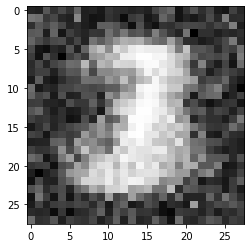

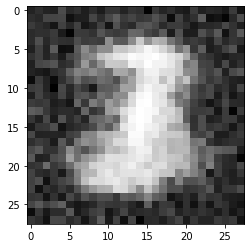

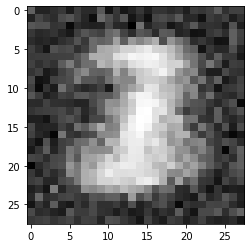

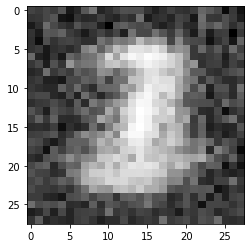

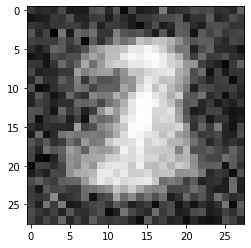

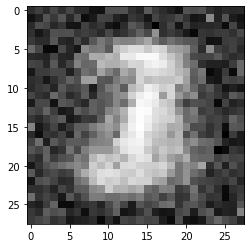

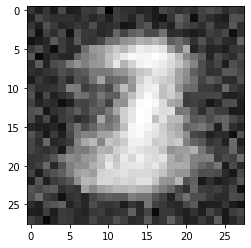

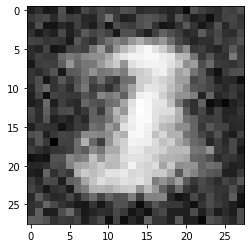

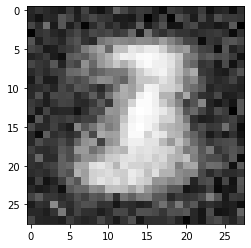

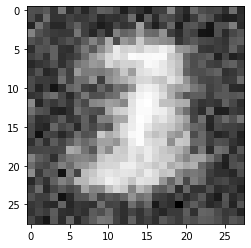

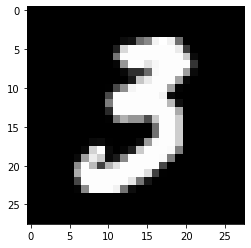

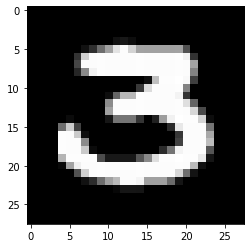

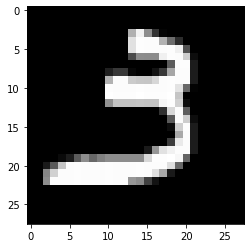

In [ ]:
#the following code trains both the discriminator and the generator
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as mplot

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        D_in = 784
        H = 50
        D_out = 1
        self.input = torch.nn.Linear(D_in, H)
        #self.sigmoid = torch.nn.LogSigmoid()
        self.hiddentoout = torch.nn.Linear(H, D_out)
        self.output = torch.nn.Sigmoid()
    def forward(self, x):
        x=self.input(x)
        #x=self.sigmoid(x)
        x=self.hiddentoout(x)
        x=self.output(x)
        return x
    def name(self):
        return "Discriminator"

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        G_in = 784
        G_H = 50
        G_out = 784
        self.input = torch.nn.Linear(G_in, G_H)
        self.sigmoid = torch.nn.LogSigmoid()
        self.hiddentooutput = torch.nn.Linear(G_H, G_out)
        self.output = torch.nn.Tanh()
    def forward(self, x):
        x=self.input(x)
        x=self.sigmoid(x)
        x = self.hiddentooutput(x)
        x=self.output(x)
        return x
    def name(self):
        return "Generator"


class Discriminator_LogProb_Loss(torch.nn.Module):
    def __init__(self):
        super(Discriminator_LogProb_Loss,self).__init__()
    def forward(self,x_d, x_g,dd,gg):
        totloss = -torch.log(dd(x_d)) - torch.log(1-dd(gg(x_g)))
        return totloss

class Generator_LogProb_Loss(torch.nn.Module):
    def __init__(self):
        super(Generator_LogProb_Loss,self).__init__()
    def forward(self,x_g,dd,gg):
        #totloss = torch.log(1-dd(gg(x_g)))
        totloss = -torch.log(dd(gg(x_g)))
        return totloss

def show_gen_data(batch_size, feat_size, model_gen, num_gen_samples_to_show=10):
     for i in range(num_gen_samples_to_show):
        z = np.random.randn(batch_size, feat_size)
        z = torch.from_numpy(z)
        z = (z.float()).view(batch_size, feat_size)

        zz = model_gen(z)
        zz=zz.data
        zz = zz.numpy()
        zz = np.reshape(zz,[28,28])
        #print(zz.shape())

        mplot.imshow(zz, cmap='gray')
        mplot.show()

        
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=1, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    args = parser.parse_args([])
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    
    feat_size = 0
    for idx, (x,y) in enumerate(train_loader):
        [a,b,picx, picy] = x.shape
        #print(x.shape)
        #print(y.shape)
        break
        
    feat_size = picx*picy
    
    N, D_in, H, D_out = args.batch_size, feat_size, 100, 1
    
    model_disc = Discriminator()
    
    model_gen = Generator()
    
    loss_fn_disc = Discriminator_LogProb_Loss() 
    loss_fn_gen = Generator_LogProb_Loss()
    
    optimizer_disc = optim.SGD(model_disc.parameters(), lr=0.01, momentum=0)
    optimizer_gen = optim.SGD(model_gen.parameters(), lr=0.01, momentum=0)

    training_data_bala = []
    one_indices = []
    two_indices = []
    three_indices = []
    i = 0
    for idx, (x,y) in enumerate(train_loader):
        if y[0] == 1 or y[0] == 2 or y[0] == 3:
            training_data_bala.append((x,y))
            if y[0] == 1:
                one_indices.append(i)
            elif y[0] == 2:
                two_indices.append(i)
            elif y[0] == 3:
                three_indices.append(i)
        i+=1   
                
    print(len(training_data_bala))
    #print(training_data_bala[0])
    
    
    inner_k_rounds = 10
    
    #learning_rate = 1e-2
    for t in range(50):
        total_avg_disc_loss = 0
        total_avg_gen_loss = 0
        num_samples_seen = 0
        num_gen_samples_seen = 0
        
        disc_rounds = 5
        
        for round_t in range(disc_rounds):
            ind_arr = np.arange(len(training_data_bala)) #start index is 1 
            np.random.shuffle(ind_arr)
            for ind in range(inner_k_rounds):
                i = ind_arr[ind]-1

                (x,y) = training_data_bala[i]

                #do a discriminator pass
                x = (x.float()).view(args.batch_size,feat_size)
                #print(x.shape)

                y = (y.float()).view(args.batch_size, 1)
                #y_pred = disc_model(x)

                #do a generator pass

                z = np.random.randn(args.batch_size,feat_size)
                z = torch.from_numpy(z)
                z = (z.float()).view(args.batch_size, feat_size)
                #z.view(args.batch_size,feat_size)

                #forward pass
                loss=loss_fn_disc(x,z,model_disc,model_gen)

                total_avg_disc_loss = total_avg_disc_loss + loss.item() 
                # Zero the gradients before running the backward pass.
                model_disc.zero_grad()
                model_gen.zero_grad()

                # Backward pass: compute gradient of the loss with respect to all the learnable
                # parameters of the model. Internally, the parameters of each Module are stored
                # in Tensors with requires_grad=True, so this call will compute gradients for
                # all learnable parameters in the model.
                loss.backward()
                optimizer_disc.step()
                #optimizer_gen.step()
                #print('*******END OF DISC ROUND ***********')
        for ind in range(inner_k_rounds):
            #do a generator pass
            z = np.random.randn(args.batch_size,feat_size)
            z = torch.from_numpy(z)
            z = (z.float()).view(args.batch_size, feat_size)
            #forward pass
            loss=loss_fn_gen(z,model_disc,model_gen)
            num_gen_samples_seen += 1
            #if(num_gen_samples_seen % 50 == 0):
            #    print('epoch: %d num gen samples : %d loss: %f' %(t,num_gen_samples_seen,(total_avg_gen_loss/num_gen_samples_seen)))
                
            total_avg_gen_loss = total_avg_gen_loss + loss.item() 
            # Zero the gradients before running the backward pass.
            model_gen.zero_grad()

            # Backward pass: compute gradient of the loss with respect to all the learnable
            # parameters of the model. Internally, the parameters of each Module are stored
            # in Tensors with requires_grad=True, so this call will compute gradients for
            # all learnable parameters in the model.
            loss.backward()
            #optimizer_disc.step()
            optimizer_gen.step()
                

        print('epoch: %d avg train disc loss: %f avg train gen loss: %f' %(t, (total_avg_disc_loss/inner_k_rounds), (total_avg_gen_loss/inner_k_rounds)))
        print('************************************************')
        #print('epoch: %d' %(t))
        
        
    
    show_gen_data( args.batch_size, feat_size, model_gen, 10) #display generator data 
    
    #show training data
    if len(one_indices)>0:
        (xx,yy) = training_data_bala[one_indices[0]]
        xx = np.asarray(xx)
        zz = np.reshape(xx,[28,28])
        mplot.imshow(zz, cmap='gray')
        mplot.show()
        
    if len(two_indices)>0:
        (xx,yy) = training_data_bala[two_indices[0]]
        xx = np.asarray(xx)
        zz = np.reshape(xx,[28,28])
        mplot.imshow(zz, cmap='gray')
        mplot.show()

    if len(three_indices)>0:
        (xx,yy) = training_data_bala[three_indices[0]]
        xx = np.asarray(xx)
        zz = np.reshape(xx,[28,28])
        mplot.imshow(zz, cmap='gray')
        mplot.show()

    #End of main()
    
        
if __name__ == '__main__':
    main()